In [ ]:
#!pip install gym 
#!pip install ale-py 
#!pip install gym[atari,accept-rom-license]==0.21.0

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
from tqdm.notebook import tqdm
import random
import gym

import torch.nn as nn
import torch.nn.functional as F


import torchvision.transforms as T



# set device
# test gpu working 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(0))

False
0


AssertionError: Torch not compiled with CUDA enabled

In [1]:
# ALE/Breakout-v5
# Breakout-v4 
# BreakoutDeterministic-v4
env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")

NameError: ignored

In [ ]:
env.reset()
terminated = False
last_img = None
while not terminated:
    env.render(mode="rgb_array")
    action = env.action_space.sample()
    observation, reward, terminated, info = env.step(action) # truncated is not returned here, probably a version thing
    last_img = observation
    if terminated:
       env.reset()
    
env.reset()
env.close()
    

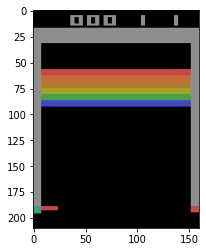

In [ ]:
plt.imshow(last_img)
plt.show()

## Preprocessing

84x84x1 as used in paper 
https://arxiv.org/pdf/1312.5602.pdf 

4.1 Preprocessing and Model Architecture

The raw frames are preprocessed by first converting their RGB representation
to gray-scale and down-sampling it to a 110×84 image.

The final input representation is obtained by
cropping an 84 × 84 region of the image that roughly captures the playing area

 note: tensor has channel as first dimension

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize, Grayscale, Resize
# No samples for calculate mean std for normalisaiton - skip
class Preprocess():
    def __init__(self, target_width = 84, target_height = 84):
        self.width = target_width
        self.height = target_height
        
        # transform
        self.transform = T.Compose([
            ToTensor(),
            Grayscale(),
            Resize((110,84))
        ])
    
    def process(self,image):
        #return self.transform(image)
        # crop to play area not clear from paper exactly which area is considered
        # tested different values
        return T.functional.crop(self.transform(image),18,0,self.height,self.width)

$\phi$ function stacks 4 images to create a state

In [ ]:
test = Preprocess()
proc_img = test.process(last_img)
print(proc_img.shape)

torch.Size([1, 84, 84])


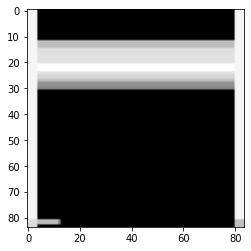

In [ ]:
# permute to get correct shape for imshow, imshow expects (height, width, channels)
plt.imshow(proc_img.permute(1, 2, 0),cmap='gray')

### Architecture
Based on https://www.nature.com/articles/nature14236

The input to the neural network consists of an 84x84x4 image produced by the preprocessing map w. 

The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. 

The second hidden layer convolves 64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.

This is followed by a third convolutional layer that convolves 64 filters of 3x3 with
stride 1 followed by a rectifier. 

The final hidden layer is fully-connected and consists of 512 rectifier units. The output layer is a fully-connected linear layer with a single output for each valid action. 

##### We have 4 valid actions!

In [ ]:
# For transfer learning, import a pretrained model and freeze the weights
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
import keras
from keras.models import Sequential

class DeepQ(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DeepQ, self).__init__()
        self.input_shape = input_shape
        self.num_actions = num_actions

        # initializer, needed for the optimizer
        # set a seeder for reproducibility
        self.initializer = keras.initializers.VarianceScaling(scale=2.0, seed=0)
        
        # convolutional layers
        self.model = Sequential()
        self.model.add(keras.layers.Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=input_shape, kernel_initializer=self.initializer))
        self.model.add(keras.layers.Conv2D(64, (4, 4), strides=(2, 2), activation='relu', kernel_initializer=self.initializer))
        self.model.add(keras.layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu', kernel_initializer=self.initializer))
        self.model.add(keras.layers.Flatten())

        # problem: expected shape=(None, 1, 210, 160, 3), found shape=(4, 210, 160, 3)
        # solution: add a batch dimension to the input
        self.model.add(keras.layers.Reshape((1, 210, 160, 3)))
        self.model.add(keras.layers.Dense(512, activation='relu', kernel_initializer=self.initializer))
        self.model.add(keras.layers.Dense(num_actions, activation='linear', kernel_initializer=self.initializer))

        # set optimizer, clipnorm is used to prevent exploding gradients
        # Adam is a good default optimizer, it is a combination of RMSProp and SGD
        self.optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)

        # TODO: can use transfer learning to load weights from a pretrained model
        #self.model.load_weights('model.h5') # or whatever the path to the weights is

    def get_q_values(self, state):
        return self.model(state)
    
    def sample_action(self, state, epsilon): # epsilon greedy action sampling
        if random.random() < epsilon:
            return random.randint(0, self.num_actions - 1)
        else:
            with torch.no_grad(): # no need to track gradients for evaluation
                return self.get_q_values(state).argmax().item()
    
    def forward(self, x): # forward pass
        return self.model(x)
    

In [ ]:
# Shape becomes [None, 1, 84, 84] for proc_img
test = DeepQ(last_img,env.action_space.n)


## Suggested by copilot

In [ ]:
# train using the gym environment

# hyperparameters
num_episodes = 1000
batch_size = 32
gamma = 0.99
learning_rate = 0.00025
target_update = 1000
replay_memory_size = 100 # 1000000
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 30000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * frame_idx / epsilon_decay)

# initialize the model
input_shape = last_img.shape
num_actions = env.action_space.n
model = DeepQ(input_shape, num_actions)
target_model = DeepQ(input_shape, num_actions)
target_model.load_state_dict(model.state_dict())
target_model.eval()


# initialize the replay memory
replay_memory = []

# initialize the frame and episode counters
frame_idx = 0
rewards = []
losses = []
all_rewards = []
episode_reward = 0

# initialize the environment
env.reset()
last_screen = env.render(mode="rgb_array")
current_screen = env.render(mode="rgb_array")
state = current_screen - last_screen
last_screen = current_screen

In [ ]:
# start training
from itertools import count
from collections import namedtuple
# Transition is used to store the experience in the replay memory
# replay memory is needed for experience replay, which is used to decorrelate the samples
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state'))

for episode in range(num_episodes):
    for t in count():
        # select epsilon-greedy action
        epsilon = epsilon_by_frame(frame_idx)
        # the model is keras, so we need to convert the state to a tensor
        state = torch.FloatTensor(state).to(device)
        action = model.sample_action(torch.FloatTensor(state).to(device), epsilon)
        
        # execute action
        _, reward, done, _ = env.step(action)
        episode_reward += reward
        
        # observe new state
        last_screen = current_screen
        current_screen = env.render(mode="rgb_array")
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        
        # store the transition in the replay memory
        replay_memory.append(Transition(state, action, reward, next_state))
        replay_memory = replay_memory[-replay_memory_size:] # keep only the last 1000000 transitions
        
        # update the state
        state = next_state
        
        # optimize the model
        if len(replay_memory) > batch_size:
            # sample a batch from the replay memory
            transitions = random.sample(replay_memory, batch_size)
            batch = Transition(*zip(*transitions))
            
            # compute a mask of non-final states and concatenate the batch elements
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
            non_final_next_states = torch.FloatTensor([s for s in batch.next_state if s is not None]).to(device)
            state_batch = torch.FloatTensor(batch.state).to(device)
            action_batch = torch.LongTensor(batch.action).to(device)
            reward_batch = torch.FloatTensor(batch.reward).to(device)
            
            # compute Q(s_t, a)
            state_action_values = model(state_batch).gather(1, action_batch.unsqueeze(1))
            
            # compute V(s_{t+1}) for all next states
            next_state_values = torch.zeros(batch_size, device=device)
            next_state_values[non_final_mask] = target_model(non_final_next_states).max(1)[0].detach()
            
            # compute the expected Q values
            expected_state_action_values = (next_state_values * gamma) + reward_batch
            
            # compute loss
            loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
            
            # optimize the model
            model.optimizer.zero_grad()
            loss.backward()
            for param in model.parameters():
                param.grad.data.clamp_(-1, 1)
            model.optimizer.step()

        if done:
            break

        frame_idx += 1

    # update the target network
    if episode % target_update == 0:
        target_model.load_state_dict(model.state_dict())

    # log results
    rewards.append(episode_reward)
    losses.append(loss.item())
    mean_100ep_reward = round(np.mean(rewards[-100:]), 1)
    mean_100ep_loss = round(np.mean(losses[-100:]), 5)
    print('Episode {}\tLast reward: {:.2f}\tAverage reward (last 100 episodes): {:.2f}\tLoss: {:.5f}'.format(episode, episode_reward, mean_100ep_reward, mean_100ep_loss))

In [ ]:
# Delete the model from memory to avoid errors
del model